In [21]:
import importlib

import iplotx as ipx
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import description_models

importlib.reload(description_models)

<module 'description_models' from '/home/petr/projects/mltests/workspace/autogen/description_models.py'>

In [155]:
from src.renderer.renderbpmn import BPMNRenderer, save_all

renderer = BPMNRenderer()

In [96]:
def layout_pos(lay, uid, b_scale, sz=(640, 480)):
    x = lay[uid]
    return ((x + np.array([1, 1])) / 2) * b_scale * np.array(sz)

/tmp/ipykernel_704232/3027077597.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


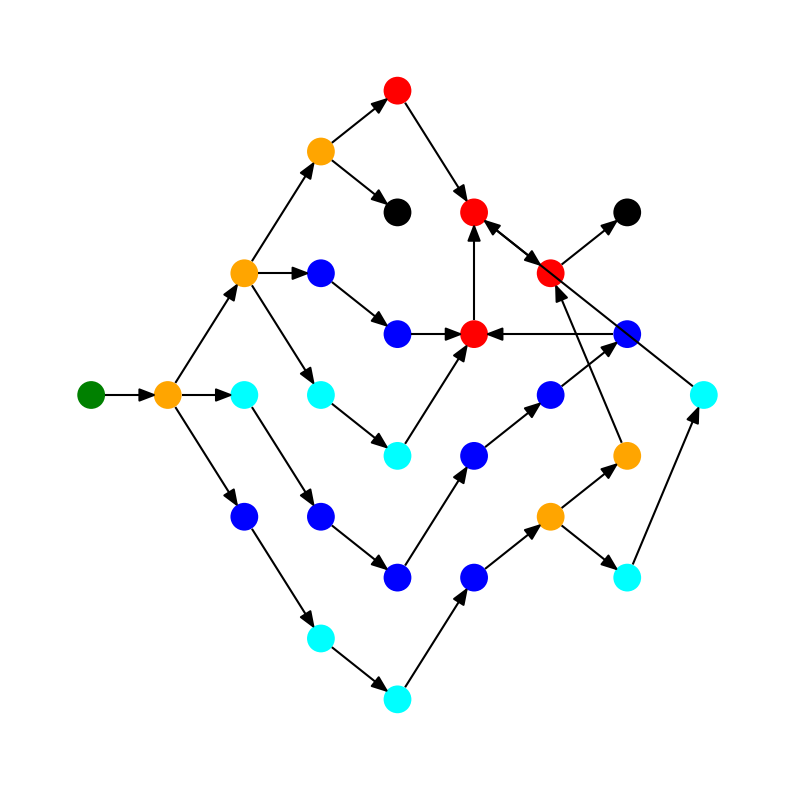

In [167]:
def gensk():
    import graphgen_skeleton
    importlib.reload(graphgen_skeleton)
    generator = graphgen_skeleton.ProbabilisticGraphGenerator()
    return generator()

sk = gensk()

colorify = dict(
    process_start="green",
    process_end="black",
    event="cyan",
    action="blue",
    fan_out="orange",
    fan_in="red",
)
vertex_color = [colorify[i['type']] for i in sk.nodes.values()]

layout = nx.bfs_layout(sk, next(iter(sk.nodes())))
fig, ax = plt.subplots(figsize=(10, 10))
ipx.plot(sk, ax=ax, layout=layout, vertex_facecolor=vertex_color)
fig.show()

In [168]:
from workspace.autogen.description_models import GBPMNElementType, GBPMNElementSubType

TYPE_MAP = {
    (GBPMNElementType.TASK, GBPMNElementSubType.TASK_OTHER): "bpmn:Task",
    (GBPMNElementType.GATEWAY, GBPMNElementSubType.GATEWAY_EVENT): "bpmn:EventBasedGateway",
    (GBPMNElementType.GATEWAY, GBPMNElementSubType.GATEWAY_EXCLUSIVE): "bpmn:ExclusiveGateway",
    (GBPMNElementType.GATEWAY, GBPMNElementSubType.GATEWAY_PARALLEL): "bpmn:ParallelGateway",
    (GBPMNElementType.GATEWAY, GBPMNElementSubType.GATEWAY_INCLUSIVE): "bpmn:InclusiveGateway",
}

def cfirst(x):
    return x[0].upper() + x[1:]

class Codegen:
    def __init__(self):
        self.code = []

    def add(self, other):
        if isinstance(other, list):
            self.code.extend(other)
        else:
            self.code.append(other)

    def add_element(self, process_id, uid, name, loc, typ, subtyp):
        # (uid, name, bpmn_type, px, py, process_id)
        bpmn_tdef = ""
        bpmn_type = TYPE_MAP.get((typ, subtyp), None)
        if bpmn_type is None:
            bpmn_type = f"bpmn:{cfirst(typ)}"
            bpmn_tdef = f"bpmn:{cfirst(subtyp)}"
        px, py = loc
        self.add(f"makeElement('{uid}', '{name}', '{bpmn_type}', '{bpmn_tdef}', {px}, {py}, '{process_id}');")

    def add_edge(self, uid1, uid2, label):
        self.add(f"makeLink('{uid1}', '{uid2}', '{label}');")

    def __str__(self):
        return "\n".join(self.code)

code = Codegen()
for i, data in g.nodes.items():
    code.add_element(
        process_id="0",
        uid=i,
        name=data['name'],
        loc=layout_pos(layout, i, b_scale=5),
        typ=data['type'],
        subtyp=data['subtype'],
    )

for (a, b), data in g.edges.items():
    code.add_edge(a, b, data['name'])

save_all(await renderer.render_by_code(code))